<a href="https://colab.research.google.com/github/sushmanthreddy/dog_breed/blob/main/dog_breed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import cv2
import random
from random import randint
import time

import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn


from PIL import Image
from scipy import ndimage


import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/kaggle/dog-breed-identification'

Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/kaggle/dog-breed-identification'


TRAIN_DIR = root_path + '/train'                           
TEST_DIR = root_path + '/test'                             

TRAIN_CSV = root_path + '/labels.csv'                     
TEST_CSV = root_path + '/submission.csv'

In [ ]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head(10)

id               breed
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo
2  001cdf01b096e06d78e9e5112d419397            pekinese
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier
7  002a283a315af96eaea0e28e7163b21b              borzoi
8  003df8b8a8b05244b1d920bb6cf451f9             basenji
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound

In [ ]:
labels_names=data_df["breed"].unique()
labels_sorted=labels_names.sort()

labels = dict(zip(range(len(labels_names)),labels_names))
labels

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [ ]:
lbl=[]
for i in range(len(data_df["breed"])):
    temp=list(labels.values()).index(data_df.breed[i])
    lbl.append(temp)

    
data_df['lbl'] = lbl
#data_df['lbl'] = data_df['lbl'].astype(str)
data_df.head(10)

id               breed  lbl
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull   19
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo   37
2  001cdf01b096e06d78e9e5112d419397            pekinese   85
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick   15
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever   49
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier   10
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier   10
7  002a283a315af96eaea0e28e7163b21b              borzoi   18
8  003df8b8a8b05244b1d920bb6cf451f9             basenji    7
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound   97

In [ ]:
path_img=[]
for i in range(len(data_df["id"])):
    temp=TRAIN_DIR + "/" + str(data_df.id[i]) + ".jpg"
    path_img.append(temp)

data_df['path_img'] =path_img
data_df.head()

id             breed  lbl  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   19   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   37   
2  001cdf01b096e06d78e9e5112d419397          pekinese   85   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   15   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   49   

                                            path_img  
0  gdrive/My Drive/kaggle/dog-breed-identificatio...  
1  gdrive/My Drive/kaggle/dog-breed-identificatio...  
2  gdrive/My Drive/kaggle/dog-breed-identificatio...  
3  gdrive/My Drive/kaggle/dog-breed-identificatio...  
4  gdrive/My Drive/kaggle/dog-breed-identificatio...

In [ ]:
num_images = len(data_df["id"])
print('Number of images in Training file:', num_images)
no_labels=len(labels_names)
print('Number of dog breeds in Training file:', no_labels)

Number of images in Training file: 10222
Number of dog breeds in Training file: 120


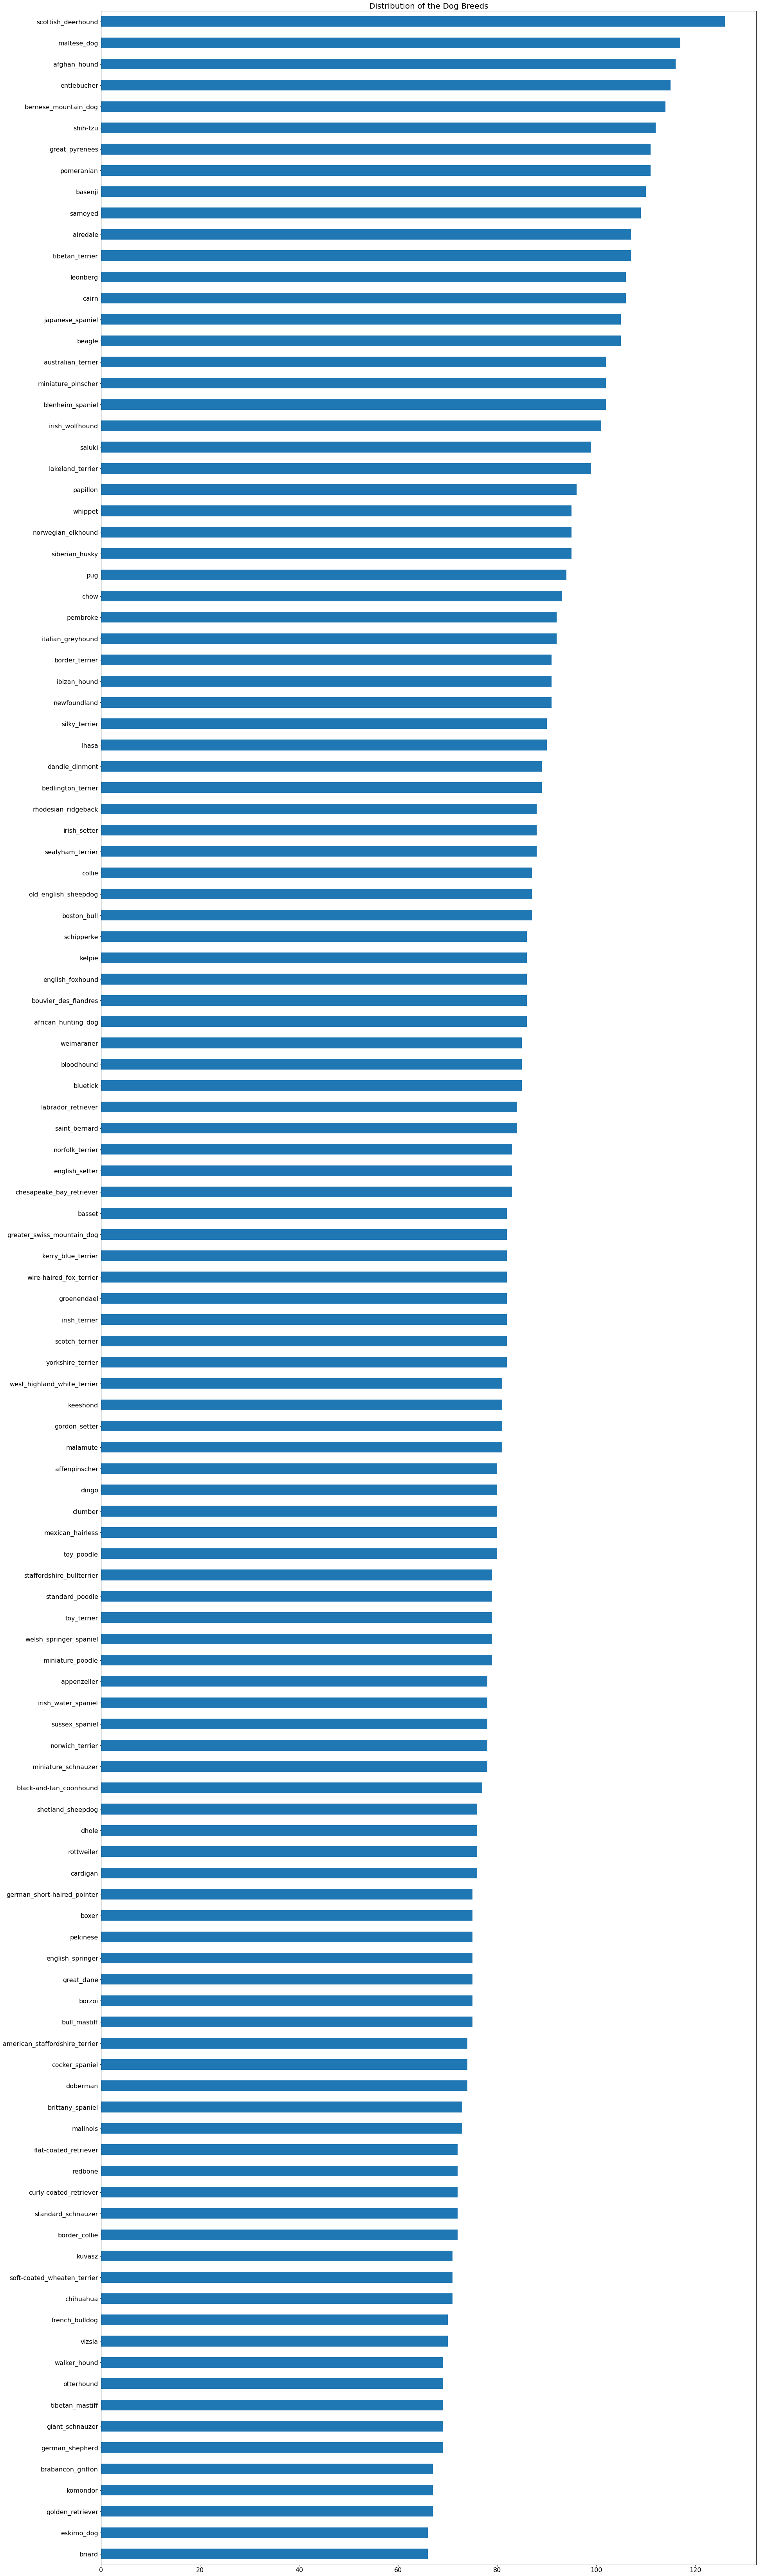

In [ ]:
bar = data_df["breed"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the Dog Breeds", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

In [ ]:
data_df["breed"].value_counts(ascending=False)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

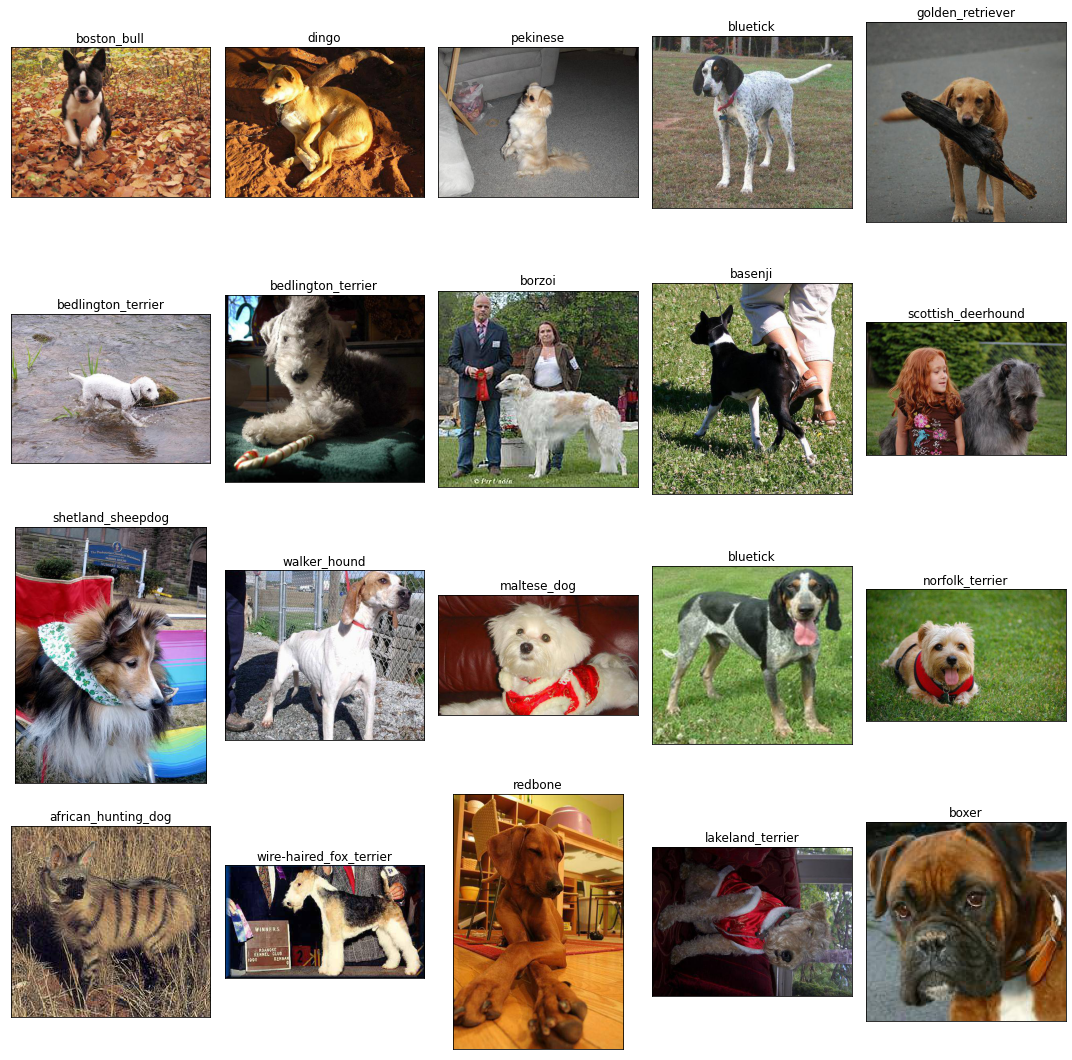

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data_df.path_img[i]))
    ax.set_title(data_df.breed[i])
plt.tight_layout()
plt.show()

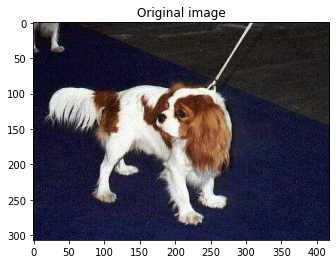

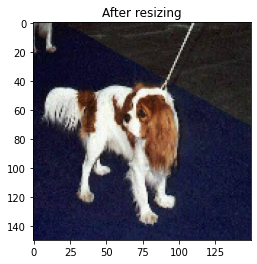

In [ ]:
random_img=randint(0,len(data_df.path_img))
img_path=data_df.path_img[random_img]
img= plt.imread(img_path)

plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

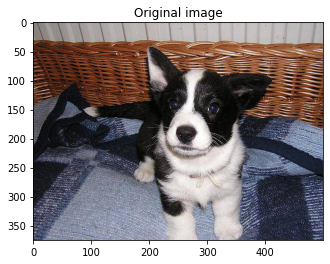

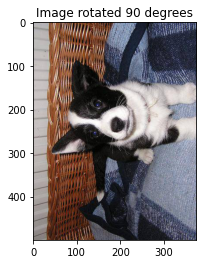

In [ ]:
random_img=randint(0,len(data_df.path_img))
img_path=data_df.path_img[random_img]
img= plt.imread(img_path)

plt.imshow(img)
plt.title("Original image")
plt.show()


#rotation angle in degree

rotated1 = ndimage.rotate(img, 90)
plt.imshow(rotated1)
plt.title("Image rotated 90 degrees")
plt.show()

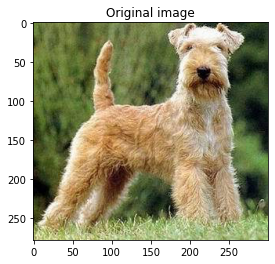

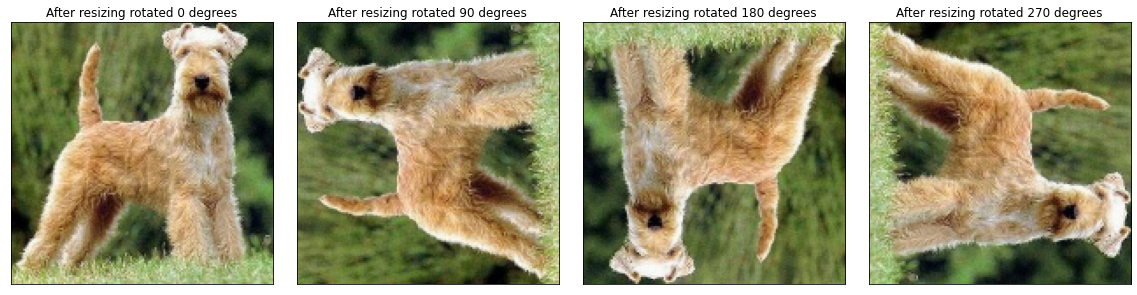

In [ ]:
random_img=randint(0,len(data_df.path_img))
img_path=data_df.path_img[random_img]
img= plt.imread(img_path)

plt.imshow(img)
plt.title("Original image")
plt.show()


img=cv2.resize(img, (150,150))
turn =90

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(ndimage.rotate(img, i*90))
    ax.set_title("After resizing rotated "+ str(i*90) +" degrees")
plt.tight_layout()
plt.show()

In [ ]:
#imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
#this will resize the image 
    T.Resize(256),   
   
#Randomly change the brightness, contrast and saturation of an image
#    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),    

#this will remove parts (crop) the Image at a random location.   
#    T.RandomCrop(32, padding=4, padding_mode='reflect'),   

#Horizontally flip (rotate by 180 degree) the given image randomly; default is 50% of images
    T.RandomHorizontalFlip(), 
    
#Rotate the image by angle -here by 10%
    T.RandomRotation(10),
    
#convert it to a tensor   
    T.ToTensor()

#Normalize a tensor image with mean and standard deviation - here with the Imagenet stats
#    T.Normalize(*imagenet_stats,inplace=True), 
    
#Randomly selects a rectangle region in an image and erases its pixels.    
#    T.RandomErasing(inplace=True)
])

In [ ]:
class DogDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['id'], row['lbl']
        img_fname = self.root_dir + "/" + str(img_id) + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [ ]:
data_ds = DogDataset(data_df, TRAIN_DIR, transform=train_tfms)

In [ ]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', labels[target])

Labels: scotch_terrier


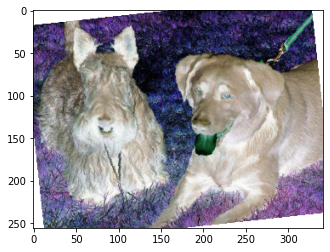

In [ ]:
show_sample(*data_ds[2011])

Labels: leonberg


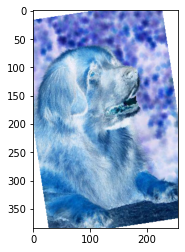

In [ ]:
show_sample(*data_ds[149])